In [115]:
import pandas as pd
import os
from os.path import join
import pylab as plt

In [149]:
# Path the data directory
outputs_dir = join(os.getcwd(), '..', 'outputs', 'test_senario')

In [183]:
gen = pd.read_csv(join(outputs_dir, 'generation.csv'))

<Axes: >

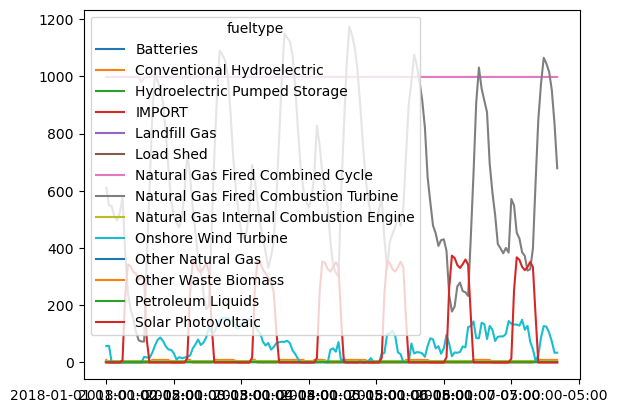

In [153]:
gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum().T.plot()

In [191]:
grouped = gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum()
grouped

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-07 15:00:00-05:00,2018-01-07 16:00:00-05:00,2018-01-07 17:00:00-05:00,2018-01-07 18:00:00-05:00,2018-01-07 19:00:00-05:00,2018-01-07 20:00:00-05:00,2018-01-07 21:00:00-05:00,2018-01-07 22:00:00-05:00,2018-01-07 23:00:00-05:00,2018-01-08 00:00:00-05:00
fueltype,,,,,,,,,,,,,,,,,,,,,
Batteries,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Conventional Hydroelectric,8.9000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.0000,8.900000,8.9000,8.900,8.9000,8.9000,8.9000,8.9000,8.9000,8.9000
Hydroelectric Pumped Storage,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
IMPORT,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Landfill Gas,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Shed,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Natural Gas Fired Combined Cycle,998.0000,998.0000,998.000,998.0000,998.0000,998.0000,998.000000,998.000000,998.000000,998.000000,...,998.0000,998.000000,998.0000,998.000,998.0000,998.0000,998.0000,998.0000,998.0000,998.0000
Natural Gas Fired Combustion Turbine,610.4039,549.0049,546.656,510.1198,496.3646,523.5261,574.847853,382.868393,242.042923,184.807614,...,398.5886,632.471216,849.1933,974.644,1064.7244,1044.4824,1015.9356,951.7954,834.1226,678.7935
Natural Gas Internal Combustion Engine,3.6000,3.6000,3.600,3.6000,3.6000,3.6000,3.600000,3.600000,3.600000,3.600000,...,3.6000,3.600000,3.6000,3.600,3.6000,3.6000,3.6000,3.6000,3.6000,3.6000


In [155]:
prices = pd.read_csv(join(outputs_dir, 'prices.csv'))

In [159]:
prices

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-07 15:00:00-05:00,2018-01-07 16:00:00-05:00,2018-01-07 17:00:00-05:00,2018-01-07 18:00:00-05:00,2018-01-07 19:00:00-05:00,2018-01-07 20:00:00-05:00,2018-01-07 21:00:00-05:00,2018-01-07 22:00:00-05:00,2018-01-07 23:00:00-05:00,2018-01-08 00:00:00-05:00
0,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
1,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
2,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
3,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
4,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
485,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
486,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
487,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,14.509844,14.48487,14.48487,...,14.509844,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472


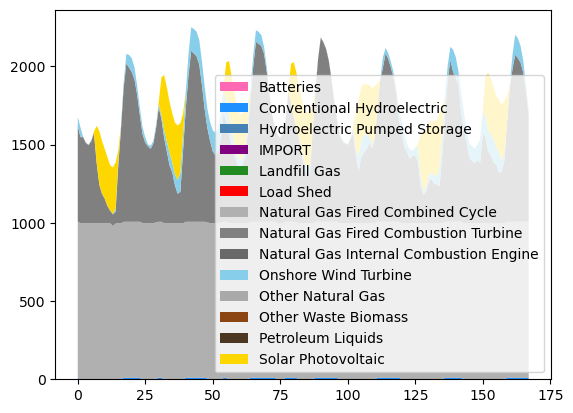

In [257]:
y = grouped.to_numpy()

fig, ax = plt.subplots()
plt.stackplot(range(len(y.T)), y, labels=grouped.index, colors=[i[1] for i in generator_colors]);
plt.legend()

In [249]:
generator_colors = [
    ("Solar Photovoltaic", "#FFD700"),
    ("Onshore Wind Turbine", "#87CEEB"),
    ("Conventional Hydroelectric", "#1E90FF"),
    ("Hydroelectric Pumped Storage", "#4682B4"),
    ("Natural Gas Fired Combined Cycle", "#B0B0B0"),
    ("Natural Gas Fired Combustion Turbine", "#808080"),
    ("Natural Gas Internal Combustion Engine", "#696969"),
    ("Other Natural Gas", "#A9A9A9"),
    ("Petroleum Liquids", "#4B3621"),
    ("Landfill Gas", "#228B22"),
    ("Other Waste Biomass", "#8B4513"),
    ("Batteries", "#FF69B4"),
    ("IMPORT", "#800080"),
    ("Load Shed", "#FF0000")
]
generator_colors.sort()